### Totally Wired BBQ

Here we will use the [Fireboard BBQ Thermometer](https://www.fireboard.com/shop/fireboard-fbx11-thermometer/) to monitor the progress of some beef short ribs smoking on the Weber Smoky Mountain.


In [87]:
import numpy,pandas
import matplotlib.pyplot as plt
import seaborn

%matplotlib inline

import requests
import json
import pandas

# function get grab session data

def get_session():
    # load auth data

    auth = json.loads(open('auth.json').readlines()[0])

    # first get session data

    response = requests.get('https://fireboard.io/api/v1/sessions.json',
                            auth=(auth['username'], auth['password']))
    # this assumes that the first session is the newest - seems correct
    session_info = response.json()[0]

    # grab session chart

    response = requests.get('https://fireboard.io/api/v1/sessions/%d/chart.json'%session_info['id'],
                            auth=(auth['username'], auth['password']))
    session_data = response.json()
    
    # print channels
    print('Detected %d channels'%len(session_data))
    for i,s in enumerate(session_data):
        print("channel 1: %s"%s['label'])
    # this assumes that air temp is probe 1 and the rest are meat temps
    offset=16*3600
    session_df = pandas.DataFrame({'Air (%s)'%session_data[0]['label'].replace('Channel','Probe'):session_data[0]['y']},
                   # need to correct date stamp to match pacific time
                    index=pandas.to_datetime([i - offset for i in session_data[0]['x']],
                                                            unit='s').tz_localize('US/Pacific'))

    for i in range(1,len(session_data)):
        session_df['Meat (%s)'%session_data[i]['label'].replace('Channel','Probe')]=session_data[i]['y']
 
    return(session_df)



In [88]:
s = get_session()

Detected 3 channels
channel 1: Channel 1
channel 1: Channel 2
channel 1: Channel 3


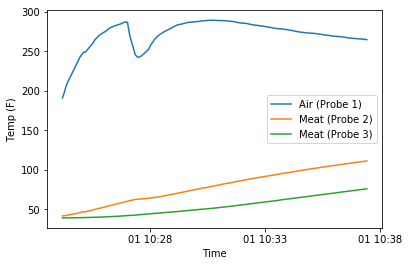

In [89]:
plt.plot(s)
plt.legend(s.columns)
plt.xlabel('Time')
_=plt.ylabel("Temp (F)")